In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import statsmodels.api as sm

## Data Preparation
This notebook will conduct linear regression on **Tesla** stock

In [198]:
dp_df = pd.read_csv('pt2-dependent.csv').iloc[:, [0, 4]]
ex_df = pd.read_csv('pt2-explainatory.csv').iloc[:, :-2]

In [220]:
new_column_names = ['datetime', 'S&P', 'Gold', 'VIX', 'DX', 'IRX', 'TYX']  

for column in ex_df.columns:
    ex_df = ex_df.rename(columns={column: new_column_names.pop(0)})

df = pd.merge(ex_df, dp_df, on='datetime')
df['datetime'] = pd.to_datetime(df['datetime'])
df.drop('datetime', axis=1, inplace=True)
df.dropna(inplace=True)

             S&P         Gold        VIX          DX    IRX    TYX  \
1    1859.449951  1321.400024  14.000000   79.779999  0.043  3.592   
2    1872.339966  1283.400024  13.880000   80.099998  0.028  3.561   
3    1883.949951  1295.599976  13.410000   79.489998  0.020  3.458   
4    1923.569946  1245.599976  11.400000   80.370003  0.030  3.314   
6    1930.670044  1281.300049  16.950001   81.459999  0.018  3.311   
..           ...          ...        ...         ...    ...    ...   
107  3839.500000  1819.699951  21.670000  103.519997  4.260  3.975   
109  3970.149902  1828.900024  20.700001  104.870003  4.710  3.931   
110  4109.310059  1969.000000  18.700001  102.510002  4.585  3.689   
111  4169.479980  1990.099976  15.780000  101.669998  4.923  3.678   
112  4179.830078  1963.900024  17.950001  104.320000  5.248  3.856   

     TSLA return  
1       0.299723  
2      -0.160783  
3      -0.002690  
4      -0.000577  
6      -0.072373  
..           ...  
107    -0.457813  
109    

## Utilty Functions

In [189]:
# Scaling Data
def scaler_method(df):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_features = scaler.fit_transform(df)
    df_feat = pd.DataFrame(scaled_features, columns=df.columns)
    df_feat["TSLA return"] = df_feat.pop("TSLA return")
    return df_feat

In [190]:
def LinearRegression(X, Y):
      X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

      model = linear_model.LinearRegression()
      model.fit(X_train, Y_train)
      Y_pred = model.predict(X_test)

      print('independent variables:', X.columns.values)
      print('Coefficients:', model.coef_)
      print('Intercept:', model.intercept_)
      print('=========Evaluation=========')
      print('Mean squared error (MSE): %.2f'
            % mean_squared_error(Y_test, Y_pred))
      print('Coefficient of determination (R^2): %.2f'
            % r2_score(Y_test, Y_pred))
      ols_result = sm.OLS(Y, X).fit()
      print(ols_result.summary())
      
      pred_Y = model.predict(X)
      result = pd.DataFrame({'index': X.index, 'Y': Y.values.flatten(), 'Y_pred': pred_Y.flatten()})

      return model, result

## Base Linear Regression Model

In [191]:
df_feat = df.copy()
for column in df_feat.columns[:-1]:
    df_feat[column + "_log"] = np.log(df_feat[column]).diff()
    df_feat = df_feat.drop(column, axis=1)
df_feat = df_feat.dropna()
df_feat_1 = scaler_method(df_feat)

<Axes: >

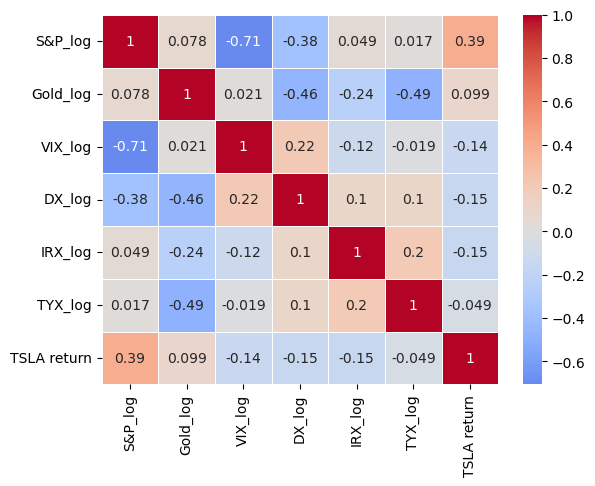

In [201]:
sns.heatmap(df_feat_1.corr(), annot=True, cmap='coolwarm', linewidths=0.5, center=0)

In [202]:
Y = df_feat_1['TSLA return']
X = df_feat_1.drop(['TSLA return'], axis=1)

In [203]:
model, result = LinearRegression(X, Y)

independent variables: ['S&P_log' 'Gold_log' 'VIX_log' 'DX_log' 'IRX_log' 'TYX_log']
Coefficients: [ 0.40253751  0.03467712  0.16437015 -0.11878938 -0.18522553  0.01080791]
Intercept: 0.04618266064635812
=========Evaluation=========
Mean squared error (MSE): 0.14
Coefficient of determination (R^2): 0.06
                                 OLS Regression Results                                
Dep. Variable:            TSLA return   R-squared (uncentered):                   0.230
Model:                            OLS   Adj. R-squared (uncentered):              0.178
Method:                 Least Squares   F-statistic:                              4.427
Date:                Sat, 17 Feb 2024   Prob (F-statistic):                    0.000580
Time:                        10:55:55   Log-Likelihood:                         -15.675
No. Observations:                  95   AIC:                                      43.35
Df Residuals:                      89   BIC:                                   

<Axes: xlabel='index'>

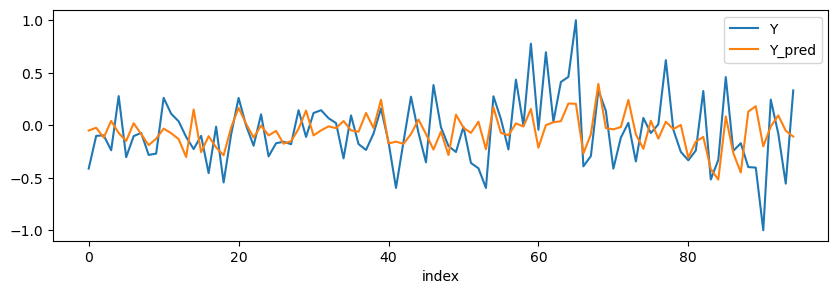

In [204]:
result.plot(x='index', y=['Y', 'Y_pred'], figsize=(10,3))

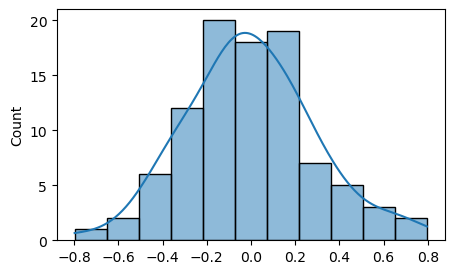

In [205]:
plt.figure(figsize=(5,3))
residual_1 = result['Y'] - result['Y_pred']
sns.histplot(residual_1, kde=True)
plt.show()

## Base Model 2

In [261]:
new_df = df.copy()

new_df['S&P_log'] = np.log(df['S&P']).diff()

new_df['TYX-IRX'] = np.log(df['TYX'] - df['IRX'])

# change VIX to log difference
new_df['VIX_log'] = np.log(df['VIX']).diff()

new_df.drop(['IRX', 'Gold', 'TYX', 'DX', 'S&P', 'VIX'], axis=1, inplace=True)

new_df.dropna(inplace=True)
new_df = scaler_method(new_df)
new_df.describe()

/Users/danielbai/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,S&P_log,TYX-IRX,VIX_log,TSLA return
count,89.000000,89.000000,89.000000,89.000000
mean,-0.101686,0.621812,-0.238068,-0.314438
std,0.375738,0.322077,0.406137,0.381701
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.316543,0.494450,-0.485908,-0.569718
50%,-0.074064,0.721368,-0.298607,-0.373367
75%,0.125717,0.835274,0.028906,-0.122675
max,1.000000,1.000000,1.000000,1.000000


<Axes: >

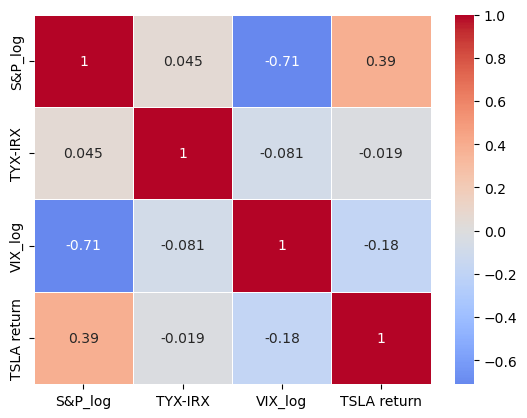

In [262]:
sns.heatmap(new_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5, center=0)

In [263]:
Y = new_df['TSLA return']
X = new_df.drop(['TSLA return'], axis=1)

In [264]:
model, result = LinearRegression(X, Y)

independent variables: ['S&P_log' 'TYX-IRX' 'VIX_log']
Coefficients: [ 0.59498503 -0.07285747  0.26442414]
Intercept: -0.1439450219090558
=========Evaluation=========
Mean squared error (MSE): 0.10
Coefficient of determination (R^2): 0.24
                                 OLS Regression Results                                
Dep. Variable:            TSLA return   R-squared (uncentered):                   0.482
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                              26.63
Date:                Sat, 17 Feb 2024   Prob (F-statistic):                    2.82e-12
Time:                        11:07:47   Log-Likelihood:                         -34.082
No. Observations:                  89   AIC:                                      74.16
Df Residuals:                      86   BIC:                                      81.63
Df Model:                           3                    

<Axes: xlabel='index'>

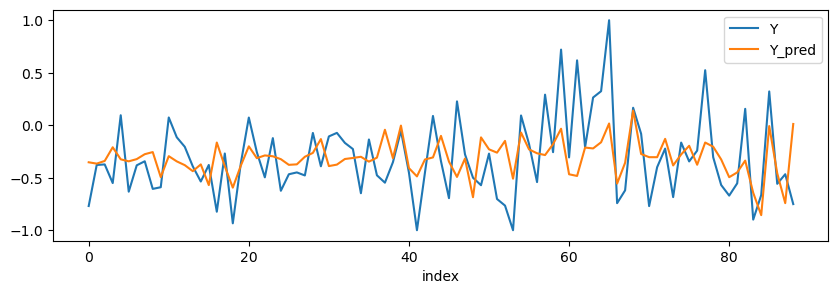

In [265]:
result.plot(x='index', y=['Y', 'Y_pred'], figsize=(10,3))

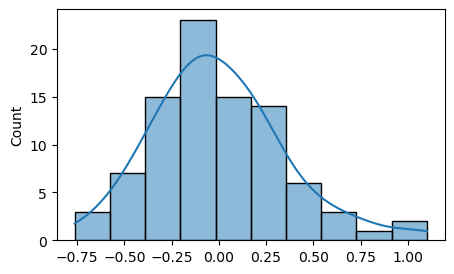

In [266]:
plt.figure(figsize=(5,3))
residual_2 = result['Y'] - result['Y_pred']
sns.histplot(residual_2, kde=True)
plt.show()